In [13]:
import json
import os
import numpy as np
import scipy.stats
from itertools import product
import matplotlib.pyplot as plt

In [2]:
results_folder = "/media/moemen/Stuff/project/data/results"

In [3]:
def get_statistics(scores_list, confidence=0.90):
    a = 1.0 * np.array(scores_list)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [4]:
def extract_results(results_dict, num_TRs, start_from):
    output_dict = {}
    for roi in results_dict.keys():
        try:
            output_dict[roi] = results_dict[roi]['num_TRs_'+str(num_TRs)]['start_from_'+str(start_from)]
        except:
            continue
    return output_dict

# Plot Results

In [6]:
os.listdir(os.path.join(results_folder, 'smoothing_0', 'per_subject'))

['results_EN_avg_filter3.json',
 'results_EN_avg_filter5.json',
 'results_EN_avg_filter7.json',
 'results_EN_avg_no_filter.json',
 'results_EN_concat_filter3.json',
 'results_EN_concat_filter5.json',
 'results_EN_concat_filter7.json',
 'results_EN_concat_no_filter.json',
 'results_FR_avg_filter3.json',
 'results_FR_avg_filter5.json',
 'results_FR_avg_filter7.json',
 'results_FR_avg_no_filter.json',
 'results_FR_concat_filter3.json',
 'results_FR_concat_filter5.json',
 'results_FR_concat_filter7.json',
 'results_FR_concat_no_filter.json']

In [28]:
results_file = os.path.join(results_folder, 'smoothing_0', 'per_subject_unshuffled', 'results_FR_concat_filter3.json')
with open(results_file, 'r') as in_file:
    results_dict = json.load(in_file)

In [32]:
rois = []
for i, key in enumerate(statistics_dict.keys()):
    rois.append(key)

0 left_amygdala
1 right_amygdala
2 right_insula
3 left_insula
4 periaqueductal
5 left_ventral_striatum
6 right_ventral_striatum
7 left_putamen
8 right_putamen
9 anterior_cingulate
10 ventromedial_prefronal
11 ventral_tegmental
12 V6
13 V1
14 noise


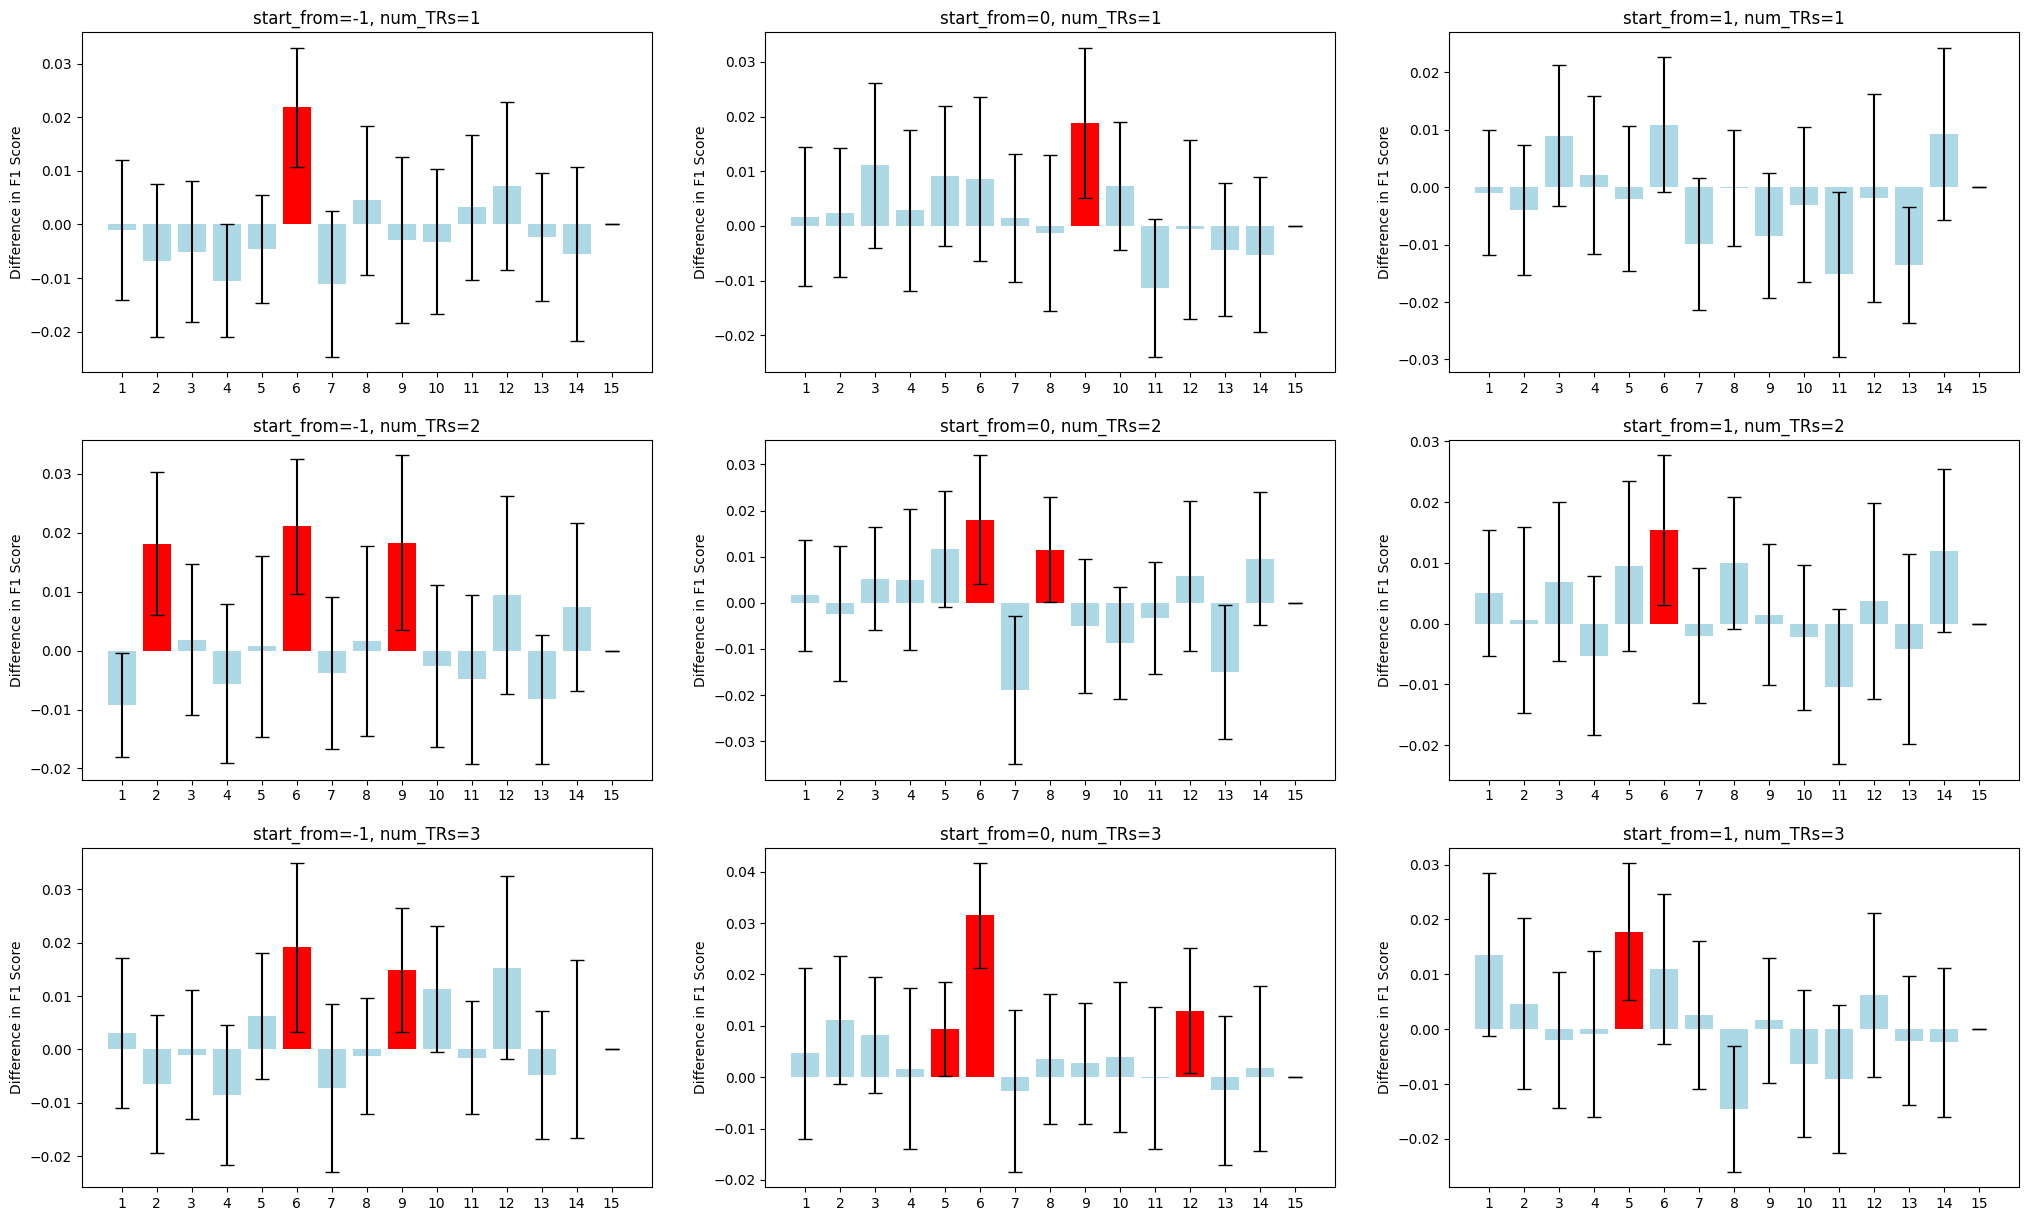

left_amygdala 0
right_amygdala 1
right_insula 0
left_insula 0
periaqueductal 2
left_ventral_striatum 6
right_ventral_striatum 0
left_putamen 1
right_putamen 3
anterior_cingulate 0
ventromedial_prefronal 0
ventral_tegmental 1
V6 0
V1 0


In [33]:
import numpy as np
import matplotlib.pyplot as plt


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(25, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

num_TRs_list = [1,2,3]
start_from_list = [-1,0,1]
combined_tuples = list(product(num_TRs_list, start_from_list))

votes = [0] * 14

for i, ax in enumerate(axes):
    num_TRs, start_from = combined_tuples[i]
    intermed_results_dict = extract_results(results_dict, num_TRs, start_from)
    statistics_dict = {}
    for roi in intermed_results_dict.keys():
        roi_scores = intermed_results_dict[roi]
        mean, lower, upper = get_statistics(roi_scores)
        statistics_dict[roi] = {'mean': mean, 'lower': lower, 'upper': upper}
        
    labels = []
    means = []
    confidence_intervals = []
    for roi in statistics_dict.keys():
        labels.append(roi)
        means.append(statistics_dict[roi]['mean'] - statistics_dict['noise']['mean'])
        confidence_intervals.append((statistics_dict[roi]['mean']-statistics_dict[roi]['lower'], statistics_dict[roi]['upper']-statistics_dict[roi]['mean']))

    significant_indices = [i for i in range(len(means)) if means[i] - confidence_intervals[i][0] > 0]
    for i in significant_indices:
        votes[i]+=1
    
#    max_index = means.index(max(means))
#    colors = ['red' if i == max_index else 'lightblue' for i in range(len(means))]
    colors = ['red' if i in significant_indices else 'lightblue' for i in range(len(means))]

    # Plot means as bars
#    ax.bar(np.arange(1,16,1), height=0, capsize=5, color=colors, label='Mean')
    ax.bar(np.arange(1,16,1), height=means, yerr=np.array(confidence_intervals).T, capsize=5, color=colors, label='Mean')

    # Set labels and title
    ax.set_ylabel('Difference in F1 Score')
    ax.set_title("start_from="+str(start_from)+', num_TRs='+str(num_TRs))
    ax.set_xticks(np.arange(1,16,1))

# Show the plot
plt.show()
for i, j in zip(rois, votes):
    print(i, j)

# Plot against voting filter width

In [20]:
num_TRs = 2
start_from = 1
lang = "FR_FR"
smoothing=0

by_filter = {}

for i in [0, 3, 5, 7]:
    if i == 0:
        results_file = os.path.join(results_folder, 'smoothing_'+str(smoothing), 'LOSO', 'results_'+lang+'_concat_no_filter.json')
    else:
        results_file = os.path.join(results_folder, 'smoothing_'+str(smoothing), 'LOSO', 'results_'+lang+'_concat_filter'+str(i)+'.json')

    with open(results_file, 'r') as in_file:
        results_dict = extract_results(json.load(in_file), num_TRs, start_from)

    statistics_dict = {}
    for roi in results_dict.keys():
        roi_scores = results_dict[roi]
        mean, lower, upper = get_statistics(roi_scores)
        statistics_dict[roi] = {'mean': mean, 'lower': lower, 'upper': upper}

    by_filter[i] = statistics_dict

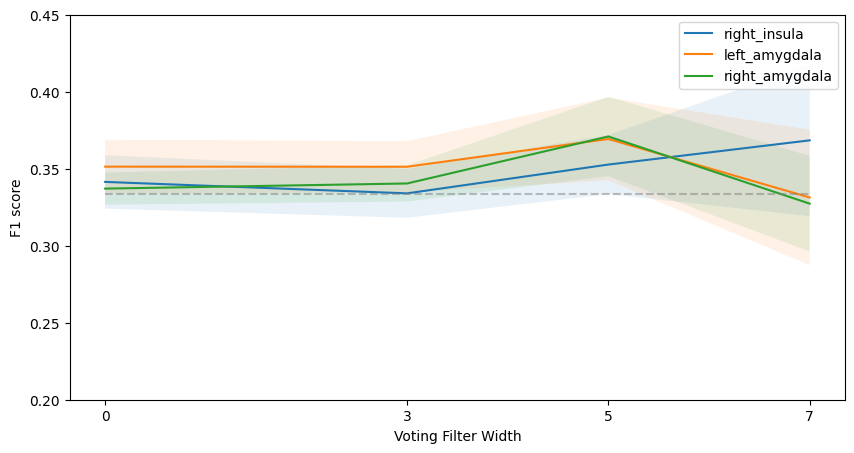

In [21]:
x_values = [0, 3, 5, 7]
plt.figure(figsize=(10, 5))
for roi in ['right_insula', 'left_amygdala', 'right_amygdala']:
    roi_values = []
    for i in x_values:
        roi_values.append(by_filter[i][roi])
    plt.plot(x_values, [y['mean'] for y in roi_values], label=roi)
    plt.fill_between(x_values, [y['lower'] for y in roi_values], [y['upper'] for y in roi_values], alpha=0.1)
    plt.xticks(x_values)
    plt.ylim([0.2, 0.45])
plt.plot(x_values, [0.33333]*len(x_values), '--', alpha=0.5, color='grey')
plt.xticks(x_values)
plt.ylabel('F1 score')
plt.xlabel('Voting Filter Width')
plt.legend()
plt.show()

# Plot against smoothing filter width

In [74]:
num_TRs = 2
start_from = 1
lang = "FR_FR"
filter="filter3"

by_smoothing = {}

for i in [0, 5, 10]:
    results_file = os.path.join(results_folder, 'smoothing_'+str(i), 'LOSO', 'results_'+lang+'_concat_'+filter+'.json')

    with open(results_file, 'r') as in_file:
        results_dict = extract_results(json.load(in_file), num_TRs, start_from)

    statistics_dict = {}
    for roi in results_dict.keys():
        roi_scores = results_dict[roi]
        mean, lower, upper = get_statistics(roi_scores)
        statistics_dict[roi] = {'mean': mean, 'lower': lower, 'upper': upper}

    by_smoothing[i] = statistics_dict

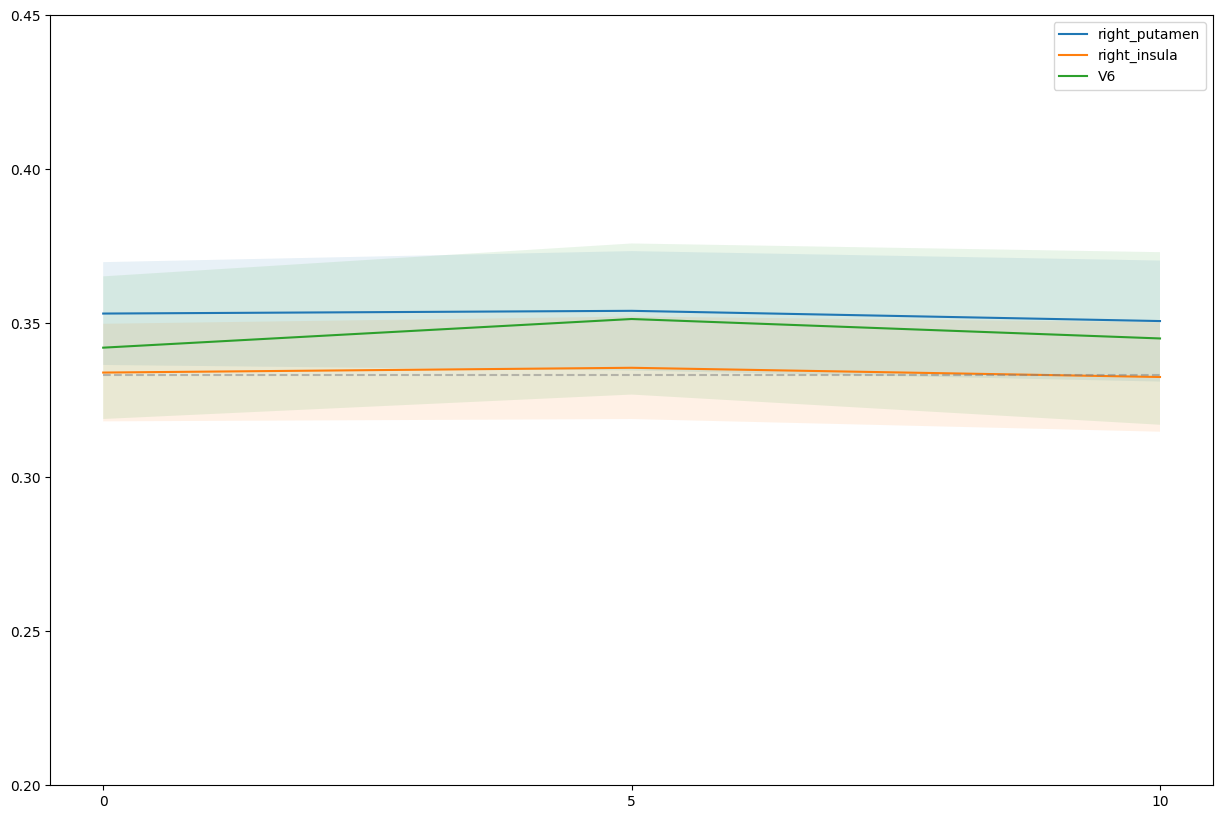

In [75]:
x_values = [0, 5, 10]
plt.figure(figsize=(15, 10))
for roi in ['right_putamen', 'right_insula', 'V6']:
    roi_values = []
    for i in x_values:
        roi_values.append(by_smoothing[i][roi])
    plt.plot(x_values, [y['mean'] for y in roi_values], label=roi)
    plt.fill_between(x_values, [y['lower'] for y in roi_values], [y['upper'] for y in roi_values], alpha=0.1)
    plt.xticks(x_values)
    plt.ylim([0.2, 0.45])
plt.plot(x_values, [0.33333]*len(x_values), '--', alpha=0.5, color='grey')
plt.legend()
plt.show()